In [1]:
import simsmex as sms
from importlib import reload
import numpy as np
import random
import math
from importlib import reload 
import msprime
import pandas as pd
import HMMmex2 as hmm
import demes
import demesdraw 
import EMmex2 as EM

import scipy
import scipy.optimize as optimize
from scipy.optimize import minimize
from numpy import linalg as LNG 

import matplotlib
from matplotlib import pyplot as plt
import seaborn
import useful2 as usfl

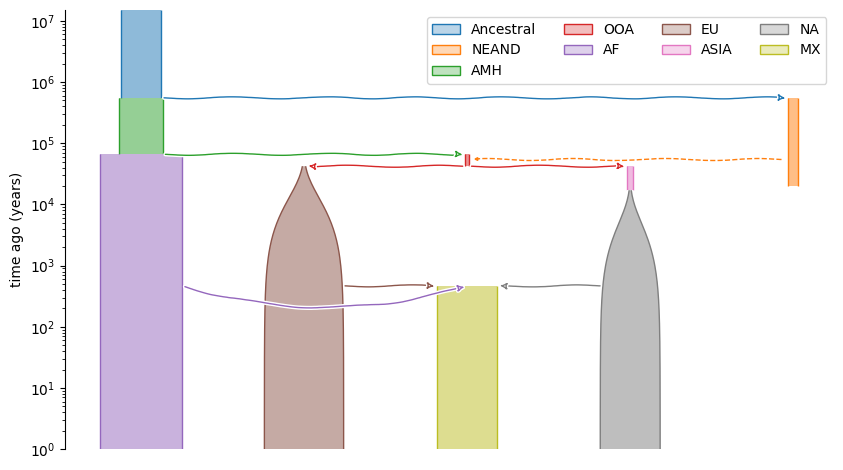

In [2]:
graph = demes.load("demes.yml")
demography = msprime.Demography.from_demes(graph)
w = demesdraw.utils.separation_heuristic(graph)
positions = dict(Ancestral=-w, AMH=-w, AF=-w, OOA=w, EU=0, NA=2 * w, MX=w, ASIA = 2*w, NEAND = 3*w)
ax = demesdraw.tubes(graph, log_time=True, positions=positions, labels="legend")

ax.figure.savefig('Mex.svg')

In [3]:
# Generation time, mutation rate and recomination rate
RR = 1e-8
MU = 1.29e-8 
GEN_time = 29.0 

# Split Times
T_NEAND_migration = 55000 #time of Neanderthal migration into Out_of_africa population
T_NEAND_AMH = 650000 # split time between AMH and Neanderthal
T_OOF_AF = 65700 # Out_of_Africa migration time
T_AS_EU_split = 41997 #Asian European split
T_AS_NA_split = 17000 # time of crossing Beringian (Nielsen et al., 2017; Mendes et al., 2020)
T_MEX_admix = 466 # postColoumb time
T_NEAND_samples = 38000

T = np.array([T_NEAND_migration, T_NEAND_AMH, T_OOF_AF, T_AS_EU_split, T_MEX_admix])/GEN_time

In [56]:
 #   print(demography.debug()) 
n_mexicans=2
n=50    
len_seq=12e7
n_neand = 8
TS = msprime.sim_ancestry(
        samples = 
        [       
                msprime.SampleSet(n_mexicans, ploidy=1, population='MX'),
                msprime.SampleSet(n, ploidy=1, population='EU'), 
                msprime.SampleSet(n, ploidy=1, population='NA'),
                msprime.SampleSet(n, ploidy=1, population='AF'),
                msprime.SampleSet(n, ploidy=1, population='NEAND', time = T_NEAND_samples/GEN_time)
               
        ],    
        ploidy=1,    
        sequence_length=len_seq,
        recombination_rate=RR, 
        demography=demography,
        record_migrations=True                                
    )

TS = msprime.sim_mutations(TS, rate=MU)

In [57]:
tractsND, tractsEU, tractsNA, tractsAF = [], [], [], []
for ind_number in range(0, n_mexicans):
    tractsND.append(sms.get_migrating_tracts_ind(TS, "NEAND", ind_number, T[0]))
    tractsEU.append(sms.get_migrating_tracts_ind(TS,"EU", ind_number, T[4]))
    tractsNA.append(sms.get_migrating_tracts_ind(TS,"NA", ind_number, T[4]))
    tractsAF.append(sms.get_migrating_tracts_ind(TS,"AF", ind_number, T[4]))

    print('DOne', ind_number)    

DOne 0
DOne 1


In [70]:
N_ref_pop_mas=[50]
N_neanderthal=6


for n_ref_pop in N_ref_pop_mas:

    with open('make.obs.sims.'+str(n_ref_pop)+'.txt', 'w') as f:
        f.write('#POSITIONS\t#REF\t#ALT\t#ANC\t#EU\t#NA\t#AF\t#ARCHAIC\t#MEX\n')
        for v in TS.variants():
            
            eu= str(list(set(v.genotypes[n_mexicans :( n_mexicans+n_ref_pop)]))).replace('[','').replace(']','').replace(' ','')
            na= str(list(set(v.genotypes[n_mexicans+n :( n_mexicans+n+n_ref_pop)]))).replace('[','').replace(']','').replace(' ','')
            af= str(list(set(v.genotypes[n_mexicans+2*n :( n_mexicans+2*n+n_ref_pop)]))).replace('[','').replace(']','').replace(' ','')
            
            archaic= str(list(set(v.genotypes[n_mexicans+3*n :( n_mexicans+3*n+N_neanderthal)]))).replace('[','').replace(']','').replace(' ','')
    
            obs=''
            for i in v.genotypes[0 :n_mexicans]:
                obs+=str(i)+' '
            
            f.write(str(int(v.site.position))+'\t'+str(v.alleles[0])+'\t'+
                    str(v.alleles[1]) + '\t'+ str(0)+'\t' + eu+'\t'+na+'\t'+af+'\t' + archaic+'\t'+str(obs)+'\n')   

In [59]:
L=1000

#create bed file
with open('test.bed','w') as f:
    f.write('1\t0\t'+str(int(len_seq)-1)+'\n')



f_bed='test.bed'
domain=usfl.read_bed(f_bed)

n_windows=(domain[-1][1]-domain[0][0])//L + 1
windows_cover=np.ones(n_windows)*0.999

#create archaic covering file. 
CHR=1
with open('arch.covering.chr'+str(CHR)+'.txt','w') as f:
    for j in windows_cover:
        f.write(str(j)+'\n')


#create file with sample's names
with open('samples.txt','w') as f:
    for i in range(int(n_mexicans/2)):
        f.write('mex'+str(i)+'\n')

In [82]:
! python3 daiseg.mex.2.py --obs_samples samples.txt --bed test.bed   --HMM_par par.file.txt --EM no --prepared_file make.obs.sims.50.txt --out_prefix out --arch_cover arch.covering.chr1.txt

Observation sequences has been created


In [84]:
! python3 daiseg.mex.2.py --obs_samples samples.txt --bed test.bed   --HMM_par par.file.txt --EM yes --EM_steps 10  --prepared_file make.obs.sims.50.txt --out_prefix out.EM --arch_cover arch.covering.chr1.txt

Observation sequences has been created
9


In [ ]:
Tracts_HMM=usfl.daiseg_mex_tracts('out.EM', n_mexicans)

df=sms.createDataFrameMex_main(Tracts_HMM, L, N_neanderthal, n_ref_pop,  tractsND,  tractsEU, tractsNA, tractsAF, 
                               [j for j in range(n_mexicans)])
df

In [ ]:
Tracts_HMM=usfl.daiseg_mex_tracts('out', n_mexicans)

df=sms.createDataFrameMex_main(Tracts_HMM, L, N_neanderthal, n_ref_pop,  tractsND,  tractsEU, tractsNA, tractsAF, 
                               [j for j in range(n_mexicans)])
df